# How does bushfire affect aquatic ecosystems in NSW?

In [1]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.ticker as ticker
import folium

In [2]:
shp_file_name = r"gda2020\nsw_localities.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip"
)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (10, 5)

In [5]:
saved_style_state = matplotlib.rcParams.copy()

In [6]:
if os.path.isfile("bushfire-water-quality-dataset.csv"):
    filepath = "bushfire-water-quality-dataset.csv"
    print("loading from file")
else:
    filepath = "https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-9e9b4c96-1a68-4dea-a5b0-23dd4cba9839/details?q="
    print("loading from the internet")
bushfire_data = pd.read_csv(filepath)
print("done")

loading from file
done


In [7]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [8]:
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests

        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, "wb") as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [9]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)
burbs.sample(2)

LC_PLY_PID          LOC_PID   DT_CREATE   LOC_NAME  \
2969  lcp4d76cd764336  locf4997159996a  2021-06-24  Narrabeen   
2244  lcpbaab4553f88b  loc03c886be333e  2021-06-24  Koolewong   

              LOC_CLASS STATE  \
2969  Gazetted Locality   NSW   
2244  Gazetted Locality   NSW   

                                               geometry  
2969  POLYGON ((151.308 -33.702, 151.308 -33.702, 15...  
2244  POLYGON ((151.325 -33.478, 151.325 -33.478, 15...

In [10]:
addreses = [f"{x}, Australia" for x in bushfire_data.Estuary.unique()]
estuary_loc_df = gp.tools.geocode(addreses)
estuary_loc_df["Estuary"] = bushfire_data.Estuary.unique()
estuary_loc_df

geometry  \
0  POINT (150.48912 -35.26980)   
1  POINT (150.30111 -35.64833)   
2  POINT (152.46843 -32.01202)   
3  POINT (150.38514 -35.48396)   
4  POINT (150.38755 -35.46131)   
5  POINT (150.11384 -36.31759)   
6  POINT (152.48614 -32.38441)   
7  POINT (150.01689 -36.60990)   
8  POINT (150.06710 -36.37050)   
9  POINT (149.93029 -37.23272)   

                                             address            Estuary  
0     Lake Conjola, 2539, New South Wales, Australia       Lake Conjola  
1            Durras Lake, New South Wales, Australia        Durras Lake  
2                 Khappinghat Creek, 2430, Australia  Khappinghat Creek  
3                        Meroo Lake, 2539, Australia         Meroo Lake  
4                      Termeil Lake, 2539, Australia       Termeil Lake  
5                  Lake Tilba Tilba, 2546, Australia   Tilba Tilba Lake  
6                       Smiths Lake, 2428, Australia        Smiths Lake  
7                            Wapengo Lake, Australia       Wapengo Lake  
8  Wallaga Lake, 2546, Bega Valley Shire Council,...       Wallaga Lake  
9                            Wonboyn Lake, Australia       Wonboyn Lake

In [30]:
lake_df = bushfire_data.merge(estuary_loc_df, on="Estuary", how="inner")
lake_df.head()

Date Time Frame            Estuary  Zone  \
0 2013-11-26   Pre-fire  Khappinghat Creek   1.0   
1 2013-11-26   Pre-fire  Khappinghat Creek   2.0   
2 2013-12-10   Pre-fire        Durras Lake   1.0   
3 2013-12-10   Pre-fire        Durras Lake   2.0   
4 2013-12-11   Pre-fire         Meroo Lake   1.0   

   Dissolved oxygen (% saturation)  Salinity (psu)    pH  \
0                        66.640000           34.93  7.58   
1                        77.980000           35.17  7.78   
2                       104.000000           30.00  7.97   
3                        99.000000           29.00  8.01   
4                        94.107296            5.96  7.80   

   Chlorophyll-a (ug/L)  Blue green algae (BGA, ug/L)  Turbidity (NTU)  \
0                  2.09                          0.19         3.513353   
1                  1.32                          0.13         4.156802   
2                  2.86                          0.31        10.720000   
3                  1.08                          0.20         4.510000   
4                  0.94                          0.03         0.550000   

   fDOM (RFU)  Dissolved nitrogen (ug/L)  Total nitrogen (ug/L)  \
0        7.29                      359.0                  395.0   
1        6.22                        NaN                    NaN   
2        5.94                        NaN                  238.0   
3        6.19                        NaN                    NaN   
4       17.95                      686.0                    NaN   

   Dissolved phosphorus (ug/L)  Total phosphorus (ug/L)  \
0                          6.2                     13.7   
1                          NaN                      NaN   
2                        350.0                      3.8   
3                          NaN                      NaN   
4                          7.6                     10.8   

   Nitrogen oxides (NOx, ug/L)  Ammonia (NH3, ug/L)  Phosphate (PO4 3-, ug/L  \
0                        3.308              24.9000                   0.5755   
1                          NaN                  NaN                      NaN   
2                       17.900               0.5411                   3.6390   
3                          NaN                  NaN                      NaN   
4                        1.487               9.1000                   0.5841   

                      geometry                                  address  
0  POINT (152.46843 -32.01202)       Khappinghat Creek, 2430, Australia  
1  POINT (152.46843 -32.01202)       Khappinghat Creek, 2430, Australia  
2  POINT (150.30111 -35.64833)  Durras Lake, New South Wales, Australia  
3  POINT (150.30111 -35.64833)  Durras Lake, New South Wales, Australia  
4  POINT (150.38514 -35.48396)              Meroo Lake, 2539, Australia

In [12]:
bushfire_data = pd.read_csv(
    filepath,
    infer_datetime_format=True,
    parse_dates=["Date"],
    dayfirst=True, 
)
bushfire_data.head(2)

C:\Users\ailee\AppData\Local\Temp\ipykernel_59388\2336673582.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  bushfire_data = pd.read_csv(


Date Time Frame       Estuary Zone  Dissolved oxygen (% saturation)  \
0 2017-10-31   Pre-fire  Lake Conjola    1                            102.1   
1 2017-10-31   Pre-fire  Lake Conjola    2                            104.4   

   Salinity (psu)    pH Chlorophyll-a (ug/L)  Blue green algae (BGA, ug/L)  \
0            33.0  7.97                 2.63                          5.56   
1            34.0  8.05                  1.5                          2.32   

  Turbidity (NTU)  fDOM (RFU) Dissolved nitrogen (ug/L)  \
0               1         3.0                     208.4   
1               0         2.0                       NaN   

   Total nitrogen (ug/L) Dissolved phosphorus (ug/L)  Total phosphorus (ug/L)  \
0                  326.5                       12.34                     22.6   
1                    NaN                         NaN                      NaN   

   Nitrogen oxides (NOx, ug/L)  Ammonia (NH3, ug/L)  Phosphate (PO4 3-, ug/L  
0                          1.0                  3.0                      0.0  
1                          NaN                  NaN                      NaN

In [13]:
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(bushfire_data.Date.min(), date_format_pattern)
latest_date = datetime.strftime(bushfire_data.Date.max(), date_format_pattern)
f"range is: {earliest_date} to {latest_date}"

'range is: November, 2013 to April, 2023'

How does bushfires affect the aquatic ecosystems in lakes of NSW?

Dataset: "2019/2020 Bushfire Inquiry project water quality dataset" from data.nsw.gov.au

Published by NSW Department of Climate Change, Energy, the ENvironment and Water on 31 May 2024

The dataset compiles the chang in levels of NSW lakes pre and post the 2019/2020 fire, with data ranging back to 2013 until 2023. The data explores different aspects that determines the suitability of water quality to aquatic ecosystems. 

In [14]:
bushfire_data.head(10)

Date Time Frame       Estuary Zone  Dissolved oxygen (% saturation)  \
0 2017-10-31   Pre-fire  Lake Conjola    1                            102.1   
1 2017-10-31   Pre-fire  Lake Conjola    2                            104.4   
2 2017-11-23   Pre-fire  Lake Conjola    1                             96.9   
3 2017-11-23   Pre-fire  Lake Conjola    2                             98.1   
4 2017-12-19   Pre-fire  Lake Conjola    1                            100.3   
5 2017-12-19   Pre-fire  Lake Conjola    2                            108.5   
6 2018-01-24   Pre-fire  Lake Conjola    1                             98.5   
7 2018-01-24   Pre-fire  Lake Conjola    2                             99.6   
8 2018-02-20   Pre-fire  Lake Conjola    2                             96.2   
9 2018-02-20   Pre-fire  Lake Conjola    1                            102.6   

   Salinity (psu)    pH Chlorophyll-a (ug/L)  Blue green algae (BGA, ug/L)  \
0            33.0  7.97                 2.63                          5.56   
1            34.0  8.05                  1.5                          2.32   
2            33.0  7.92                  2.5                          6.15   
3            34.0     8                 1.06                          2.39   
4            34.0   7.8                 2.61                          3.56   
5            34.0  7.91                 1.58                          1.73   
6            34.0  7.88                 3.52                          4.85   
7            34.0  7.91                 2.79                          3.73   
8            35.0  7.99                 9.59                         11.55   
9            35.0  8.01                11.29                         11.52   

  Turbidity (NTU)  fDOM (RFU) Dissolved nitrogen (ug/L)  \
0               1         3.0                     208.4   
1               0         2.0                       NaN   
2               1         3.0                       NaN   
3               1         2.0                       NaN   
4               1         4.0                     225.7   
5               0         2.0                       NaN   
6               1         3.0                       NaN   
7               0         3.0                       NaN   
8               0         3.0                       NaN   
9               1         3.0                     226.2   

   Total nitrogen (ug/L) Dissolved phosphorus (ug/L)  Total phosphorus (ug/L)  \
0                  326.5                       12.34                   22.600   
1                    NaN                         NaN                      NaN   
2                    NaN                         NaN                      NaN   
3                    NaN                         NaN                      NaN   
4                  287.7                    -1.97426                    6.388   
5                    NaN                         NaN                      NaN   
6                    NaN                         NaN                      NaN   
7                    NaN                         NaN                      NaN   
8                    NaN                         NaN                      NaN   
9                  155.2                        7.96                   18.490   

   Nitrogen oxides (NOx, ug/L)  Ammonia (NH3, ug/L)  Phosphate (PO4 3-, ug/L  
0                      1.00000               3.0000                   0.0000  
1                          NaN                  NaN                      NaN  
2                          NaN                  NaN                      NaN  
3                          NaN                  NaN                      NaN  
4                      0.03515               0.2326                   0.6248  
5                          NaN                  NaN                      NaN  
6                          NaN                  NaN                      NaN  
7                          NaN                  NaN                      NaN  
8                         

Bushfire

What is a bushfire and how did it occur in Australia in 2019-20?

Bushfire is a wildfire that burns in areas with wild vegetation. They occur due to hot and dry weather and can exponentially spread through lands, making it hard to control. September of 2019 was the start of the fire. It worsened through the months as Australia was approaching its summer, where the temperature heightened and a drought continued. Strong winds intensified the severity of the bushfire. A rainstorm then came in mid-February which extinguished a majority of the fire. By March, the fire was fully extinguished or contained. 

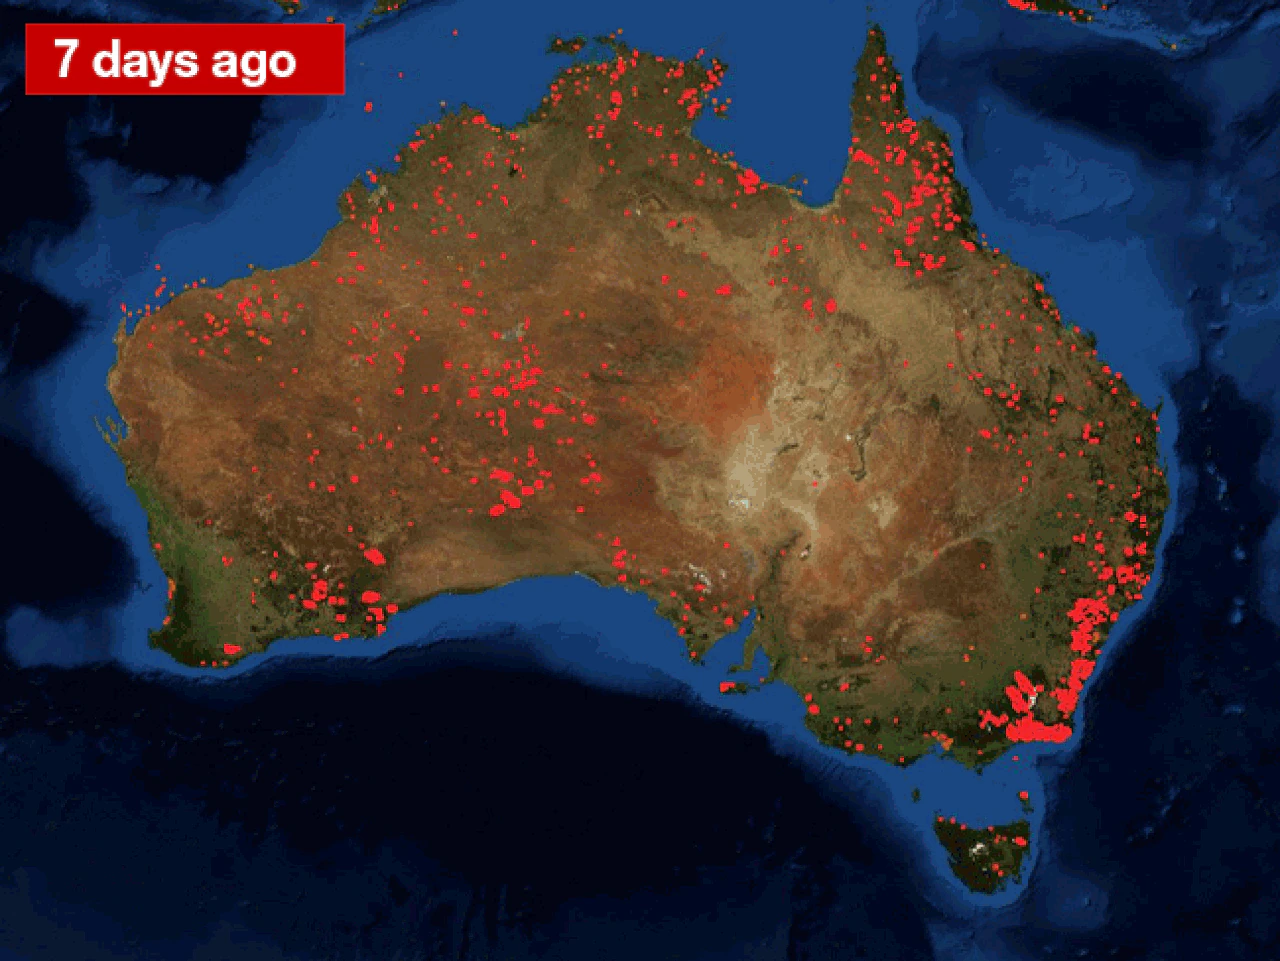

Figure 1: Australia bushfire affected area, 06-01-2020


In [15]:
from IPython.display import Image

with open("australia bushfire.webp", "rb") as file:
    display(Image(file.read()))
    print("Figure 1: Australia bushfire affected area, 06-01-2020")

In [102]:
bushfire_data.Estuary.unique()

array(['Khappinghat Creek', 'Durras Lake', 'Meroo Lake', 'Termeil Lake',
       'Smiths Lake', 'Wapengo Lake', 'Tilba Tilba Lake', 'Wonboyn Lake',
       'Wallaga Lake', 'Lake Conjola'], dtype=object)

The 10 lakes listed are lakes spread across NSW, as seen on the map below. 

Text(0.5, 1.0, 'Map of Lakes in NSW')

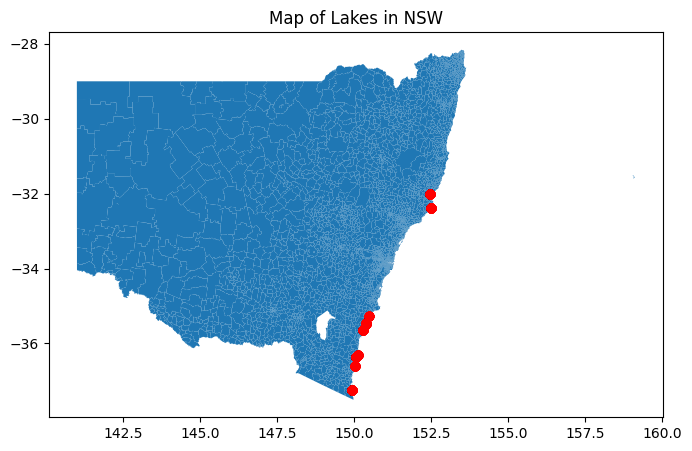

In [98]:
ax = burbs.plot()
gp.GeoDataFrame(lake_df).geometry.plot(ax=ax, c="r")
plt.title("Map of Lakes in NSW")

Text(0.5, 1.0, 'Map of Lakes in NSW')

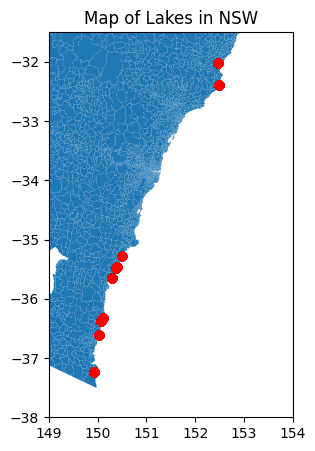

In [99]:
ax = burbs.plot()
ax.set_xlim(left=149, right=154)
ax.set_ylim(top=-31.5, bottom=-38)
gp.GeoDataFrame(lake_df).geometry.plot(ax=ax, c="r")
plt.title("Map of Lakes in NSW")

When looking at this map and the bushfire map (Figure 1) side by side, there is an overalpping of red points. This indicates that the areas impacted by the bushfires were most probably surrounding the lakes. 

In [19]:
bushfire_data['Time Frame'] = bushfire_data['Time Frame'].astype(str)

num_cols = bushfire_data.columns.difference(['Time Frame', 'Estuary'])

bushfire_data[num_cols] = bushfire_data[num_cols].apply(pd.to_numeric, errors='coerce')

average_pre_fire = (
    bushfire_data[bushfire_data["Time Frame"] == "Pre-fire"].groupby("Estuary")[num_cols].mean()
)
average_post_fire = (
    bushfire_data[bushfire_data["Time Frame"] == "Post-fire"].groupby("Estuary")[num_cols].mean()
)

average_post_fire

Ammonia (NH3, ug/L)  Blue green algae (BGA, ug/L)  \
Estuary                                                                
Durras Lake                  68.428571                      9.942222   
Khappinghat Creek            37.800000                      9.905789   
Lake Conjola                 88.600000                     11.636948   
Meroo Lake                  651.600000                     10.011875   
Smiths Lake                   3.860000                      6.966818   
Termeil Lake                 45.760000                     10.217500   
Tilba Tilba Lake              5.060000                      9.282187   
Wallaga Lake                 12.432421                     15.042767   
Wapengo Lake                  9.780000                      5.946250   
Wonboyn Lake                 28.161765                      5.796667   

                   Chlorophyll-a (ug/L)          Date  \
Estuary                                                 
Durras Lake                    5.167500  1.635610e+18   
Khappinghat Creek              4.843500  1.630841e+18   
Lake Conjola                   6.547340  1.620531e+18   
Meroo Lake                     5.341875  1.603714e+18   
Smiths Lake                    3.531970  1.629282e+18   
Termeil Lake                   8.389375  1.603714e+18   
Tilba Tilba Lake               5.615625  1.642437e+18   
Wallaga Lake                   4.926542  1.638655e+18   
Wapengo Lake                   4.115625  1.642394e+18   
Wonboyn Lake                   2.187091  1.644593e+18   

                   Dissolved nitrogen (ug/L)  Dissolved oxygen (% saturation)  \
Estuary                                                                         
Durras Lake                              NaN                       100.444444   
Khappinghat Creek                 502.820000                        92.194048   
Lake Conjola                      524.000000                       101.250000   
Meroo Lake                       1421.120000                        88.900059   
Smiths Lake                       276.970000                        99.045072   
Termeil Lake                      883.860000                       100.256250   
Tilba Tilba Lake                  457.510000                       102.702813   
Wallaga Lake                      336.446408                       106.100054   
Wapengo Lake                      171.030000                       100.555000   
Wonboyn Lake                      326.750000                        90.399266   

                   Dissolved phosphorus (ug/L)  Nitrogen oxides (NOx, ug/L)  \
Estuary                                                                       
Durras Lake                         810.985714                    28.400000   
Khappinghat Creek                     7.850000                   115.800000   
Lake Conjola                          9.800000                   112.400000   
Meroo Lake                            6.200000                    23.140000   
Smiths Lake                           3.870000                     0.950000   
Termeil Lake                          9.380000                    86.100000   
Tilba Tilba Lake                     25.670000                     1.944444   
Wallaga Lake                         14.311396                    53.284965   
Wapengo Lake                          7.200000                     1.944444   
Wonboyn Lake                          5.218750                    70.147059   

                   Phosphate (PO4 3-, ug/L  Salinity (psu)  \
Estuary                                                      
Durras Lake                      25.728571       27.277778   
Khappinghat Creek                 1.780000       26.704524   
Lake Conjola                      4.300000       18.357143   
Meroo Lake                        1.500000       13.815000   
Smiths Lake                       0.900000       31.210145   
Termeil Lake                      1.300000       14.457500   
Tilba Tilba Lake                  7.530000       28

In [57]:
def plot_estuary_data(df, estuary_name, column_name):
    estuary_df = df[df["Estuary"] == estuary_name].dropna(subset=[column_name])
    plt.plot(
        estuary_df["Date"],
        estuary_df[column_name],
        label=f"{estuary_name}",
    )

bushfire_data['Date'] = pd.to_datetime(bushfire_data['Date'])
bushfire_data.sort_values('Date', inplace=True)

### How did the water quality in these lakes change?

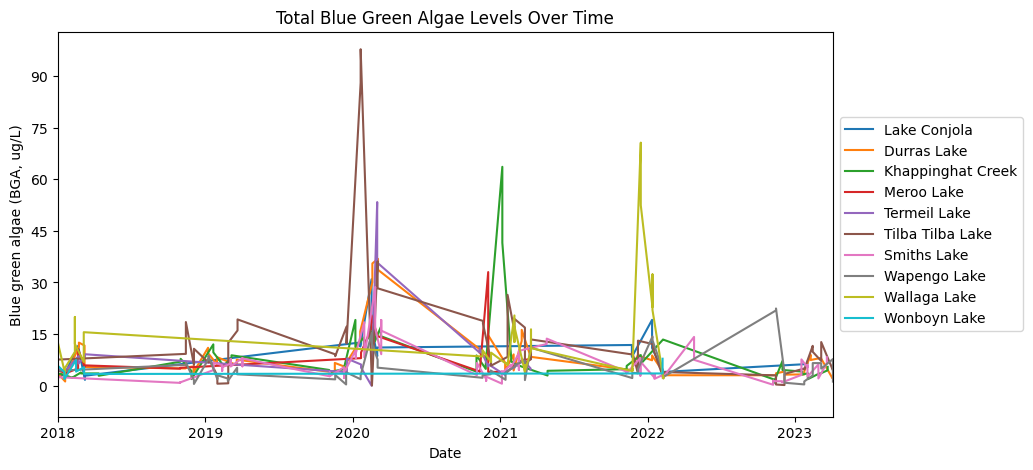

In [95]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "Blue green algae (BGA, ug/L)"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title("Total Blue Green Algae Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Ever since the bushfire happened, spikes in blue green algae levels were recorded from multiple lakes throughout NSW. 

What are they and why are their significant?

Blue-green algae, also known as a microscopic bacteria named Cyanobacteria, are commonly found in bodies of water such as rivers, lakes, and dams. They are a natural threat to water quality due to a phenomenon called 'algal blooms', where they rapidly multiply into an unhealthy amount. They produce various types of toxins (hepatoxins, neurotoxins, and endotoxins) that are not only harmful to aquatic behaviour but also for human health. 

The algaes first reached its peak in 2020, right around the time the Bushfires were ongoing. It then also heightened a few more times in the continuing years. However, the correlation between the appearance of the bushfires and the influx in blue algae are not apparent from this graph alone. 

So, how does blue-green algal blooms tie back to the bushfires?

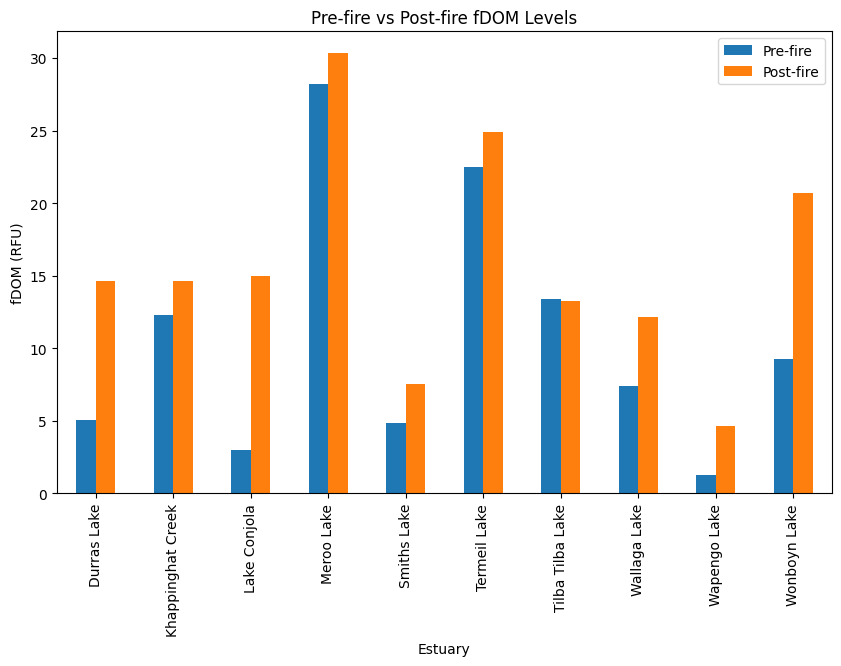

fDOM: Fluorescent Dissolved Organic Matter


In [59]:
fDOM_data = pd.DataFrame({
    'Pre-fire': average_pre_fire["fDOM (RFU)"],
    'Post-fire': average_post_fire["fDOM (RFU)"]
})

fDOM_data.plot(kind='bar', figsize=(10, 6))

plt.title('Pre-fire vs Post-fire fDOM Levels')
plt.xlabel('Estuary')
plt.ylabel('fDOM (RFU)')

plt.show()
print("fDOM: Fluorescent Dissolved Organic Matter")

A visible impact of bushfire was how it altered NSW's vegetation and soil. A lot of runoffs from this event went into the waters, introducing organic compounds from soils and vegetations into the lakes. The influx of organic materials mainly alter two main aspects of water, which are color and light availibility. 

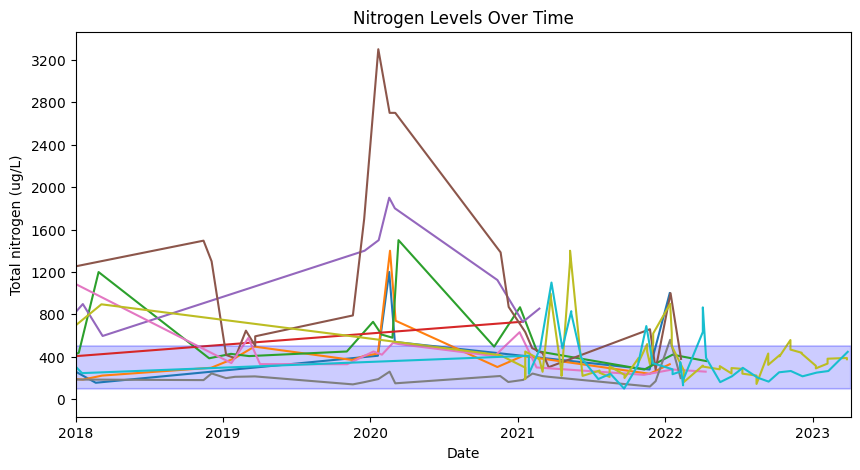

In [124]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

dates = bushfire_data["Date"]
healthy_minrange = [100] * len(dates)
healthy_maxrange = [500] * len(dates)

plt.figure()
for estuary in estuaries:
    plot_estuary_data(bushfire_data, estuary, "Total nitrogen (ug/L)")

plt.plot(dates, healthy_minrange, label="Custom Line 1", color='blue', alpha=0.1)
plt.plot(dates, healthy_maxrange, label="Custom Line 2", color='blue', alpha=0.1)

plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.2, label='Highlighted Area')

plt.title("Nitrogen Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)
plt.show()

Runoffs from vegetation and soil also leads to nutrient loading, where it releases high amount of nitrogen and phoshporus into lakes. Nutrient levels in lakes become exponentially higher, creating an inbalance in water composition. These nutrients act as a fertilizer for algaes, boosting their growth and triggering the algal blooms. Generally, the high and lows of levels appear in relatively similar time periods for the two chemicals.

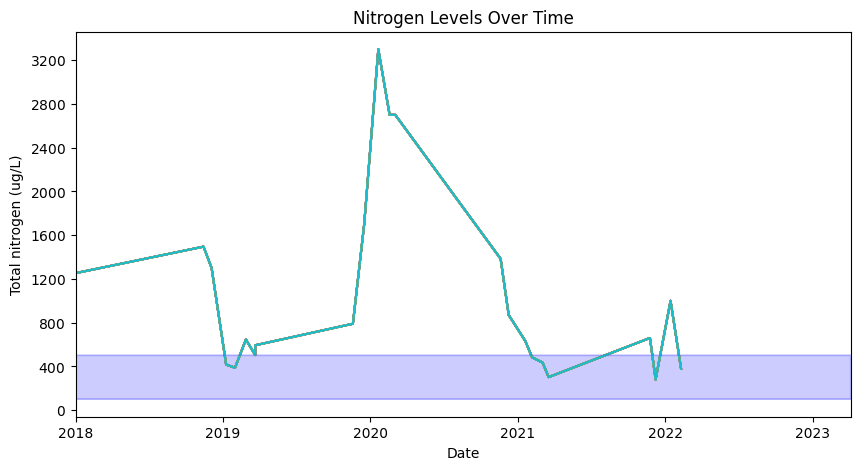

In [125]:
dates = bushfire_data["Date"]
healthy_minrange = [100] * len(dates)
healthy_maxrange = [500] * len(dates)

plt.figure()
for estuary in estuaries:
    column = "Total nitrogen (ug/L)"
    plot_estuary_data(bushfire_data, "Tilba Tilba Lake", column)

plt.plot(dates, healthy_minrange, label="Custom Line 1", color='blue', alpha=0.1)
plt.plot(dates, healthy_maxrange, label="Custom Line 2", color='blue', alpha=0.1)

plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.2, label='Highlighted Area')

plt.title("Nitrogen Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)
plt.show()

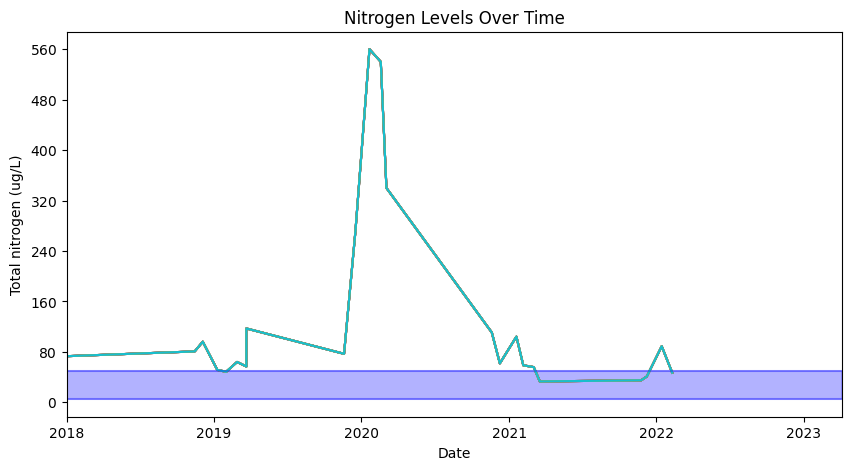

In [126]:
dates = bushfire_data["Date"]
healthy_minrange = [5] * len(dates)
healthy_maxrange = [50] * len(dates)

plt.figure()
for estuary in estuaries:
    plot_estuary_data(bushfire_data, "Tilba Tilba Lake", "Total phosphorus (ug/L)")

plt.plot(dates, healthy_minrange, label="Custom Line 1", color='blue', alpha=0.3)
plt.plot(dates, healthy_maxrange, label="Custom Line 2", color='blue', alpha=0.3)

plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.3, label='Highlighted Area')

plt.title("Nitrogen Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)
plt.show()

By looking at the graph, it seems that the levels were high by a substantial different for Tilba Tilba lake in 2020, nitrogen levels reaching 3200 ug/L and phosphorus levels reaching 560 ug/L. 

We've gone over the cause of algal blooms,

How about its impacts to the lakes?

A sign of an algal bloom is a lake's turbidity. Turbidity refers to the cloudiness of a liquid, mainly due to the levels of small particles that are invisible to the naked eye. Turbidity can hint on the amount of light that can reach the bottom of the lake. As the lake becomes more cloudy, submerged aquatic plants and species receive inadequate amount of light, impeding biological processes such as photosynthesis.

The influx in fDOM is also apparent through the levels of turbidity, due to the increase in particles from runoffs pushed into the waters. Thus, fDOM and turbidity go hand in hand, Turbidity is directly proportional to fDOM.

In this case, turbidity is not only affected by fDOM, but also from algal bloom.

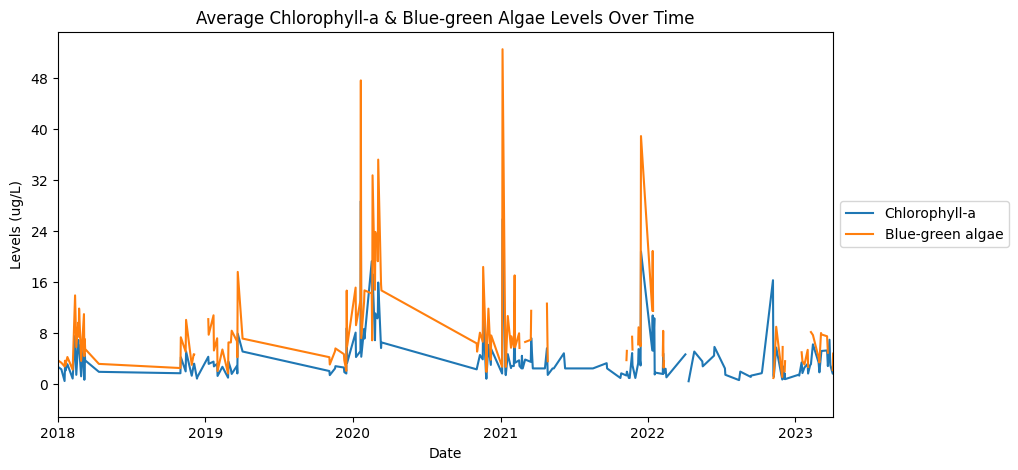

In [61]:
filtered_estuary_data = bushfire_data[bushfire_data['Estuary'].isin(estuaries)]

datec_data = filtered_estuary_data.groupby('Date')['Chlorophyll-a (ug/L)'].mean().reset_index()
dateb_data = filtered_estuary_data.groupby('Date')['Blue green algae (BGA, ug/L)'].mean().reset_index()


plt.figure()
plt.plot(datec_data['Date'], datec_data['Chlorophyll-a (ug/L)'], label='Chlorophyll-a')
plt.plot(dateb_data['Date'], dateb_data['Blue green algae (BGA, ug/L)'], label='Blue-green algae')

plt.title("Average Chlorophyll-a & Blue-green Algae Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data['Date'].max())
plt.ylabel("Levels (ug/L)")

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


Chlorophyll-a is a pigment that helps algaes photosynthesis. As chlorophyll-a is part of blue-green algaes, the trends in levels are almost identical, except for the values that they have. Increased levels can lead to alteration in color and odor, producing green scums and a bad smell. Lakes that are dominantly green can indicate overproduction of algae. The algaes can reduce light penetration into the lake and affect the aquatic ecosystem.

In [62]:
from IPython.display import display

pre_fire_df = lake_df[lake_df['Time Frame'] == 'Pre-fire']
post_fire_df = lake_df[lake_df['Time Frame'] == 'Post-fire']

m = folium.Map(location=[-34.5, 151.5], zoom_start=7)

for idx, row in pre_fire_df.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=row['Turbidity (NTU)'] * 1, 
        color='tan',
        fill=True,
        fill_color='tan',
        fill_opacity=0.5,
        popup=f"Pre-fire Turbidity: {row['Turbidity (NTU)']}"
    ).add_to(m)

for idx, row in post_fire_df.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=row['Turbidity (NTU)'] * 1,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.5,
        popup=f"Post-fire Turbidity: {row['Turbidity (NTU)']}"
    ).add_to(m)

display(m)

The plot sizes in the maps indicate turbidity levels of each lakes, with the tan colored plot being value for pre-fire and the red plot for post-fire. The turbidity varies for the two time frames, but as the map zooms out, it becomes clearer that post-fire turbidity reaches higher numbers.

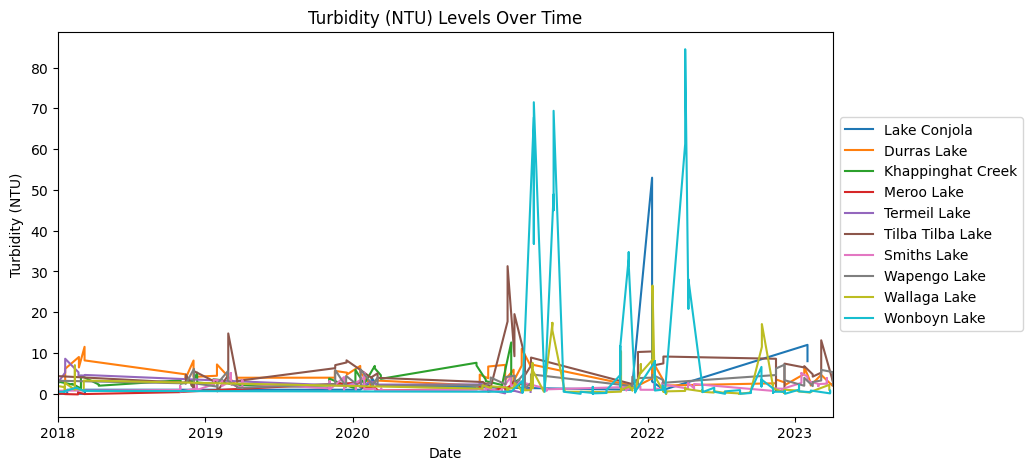

In [63]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "Turbidity (NTU)"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Meanwhile, this graph shows the peaks of turbidity over the years. The latter years shows that turbidity reached its peak after the bushfire. On the other hand, turbidity has always stuck between 0 - 10 NTU, more or less. The post-fire levels are especially high for Wonboyn Lake, which could point to how location may correlate with the severities in impact of the bushfire.

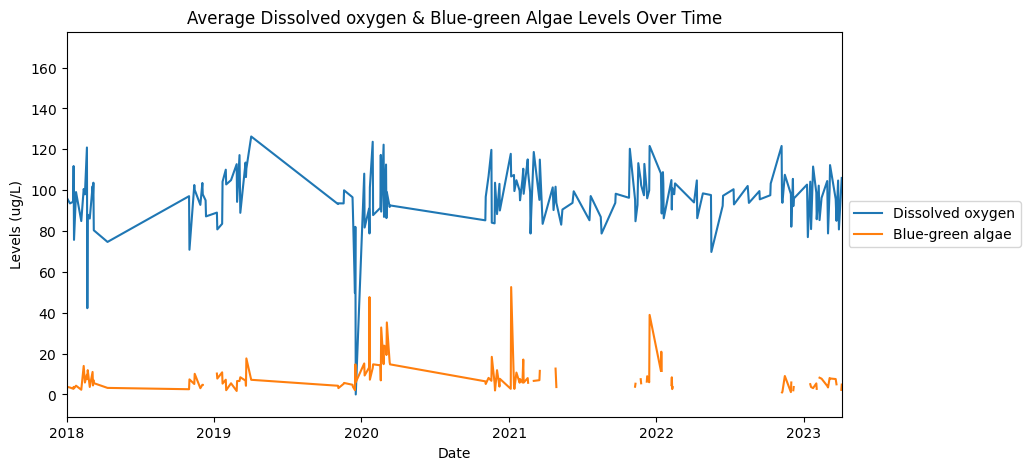

In [89]:
filtered_estuary_data = bushfire_data[bushfire_data['Estuary'].isin(estuaries)]

datec_data = filtered_estuary_data.groupby('Date')['Dissolved oxygen (% saturation)'].mean().reset_index()
dateb_data = filtered_estuary_data.groupby('Date')['Blue green algae (BGA, ug/L)'].mean().reset_index()
penalty_data.nice_day.value_counts().plot(kind="bar")

plt.figure()
plt.plot(datec_data['Date'], datec_data['Dissolved oxygen (% saturation)'], label='Dissolved oxygen')
plt.plot(dateb_data['Date'], dateb_data['Blue green algae (BGA, ug/L)'], label='Blue-green algae')

plt.title("Average Dissolved oxygen & Blue-green Algae Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data['Date'].max())
plt.ylabel("Levels (ug/L)")

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


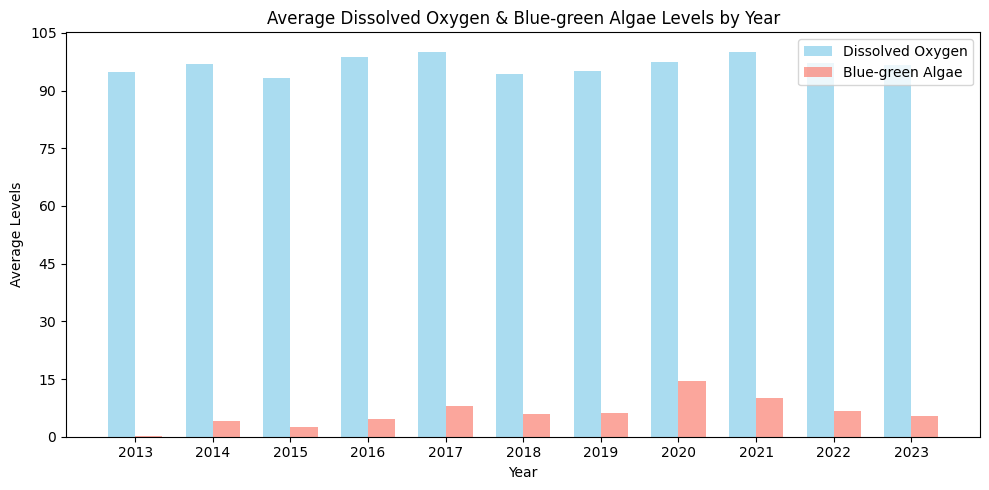

In [93]:
filtered_estuary_data = bushfire_data[bushfire_data['Estuary'].isin(estuaries)]

filtered_estuary_data['Year'] = filtered_estuary_data['Date'].dt.year

annual_data = filtered_estuary_data.groupby('Year').agg({
    'Dissolved oxygen (% saturation)': 'mean',
    'Blue green algae (BGA, ug/L)': 'mean'
}).reset_index()

bar_width = 0.35
index = range(len(annual_data))

plt.bar(index, annual_data['Dissolved oxygen (% saturation)'], bar_width, label='Dissolved Oxygen', color='skyblue', alpha=0.7)
plt.bar([i + bar_width for i in index], annual_data['Blue green algae (BGA, ug/L)'], bar_width, label='Blue-green Algae', color='salmon', alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Average Levels")
plt.title("Average Dissolved Oxygen & Blue-green Algae Levels by Year")
plt.xticks([i + bar_width / 2 for i in index], annual_data['Year'])

plt.legend(loc="best")

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.tight_layout()
plt.show()


Enough of Blue-green Algae... 

How did the bushfire affect the other aspects of the aquatic ecosystem??

Bushfire can also change a lake's pH due to the chemicals that enter the waters. pH relates to the acididty and alkalinity of a liquid. pH below 7 is acidic while pH over 7 is alkaline. It is factor that contributes to suitable water quality for the aquatic species in lakes. Drastic changes out of the normal range, as well as changes that occur to quickly may induce physiological stess to species. This may create negative outcomes such as less growth, reproduction and the occurances of diseases. Thus, aquatic lives might be in danger. 

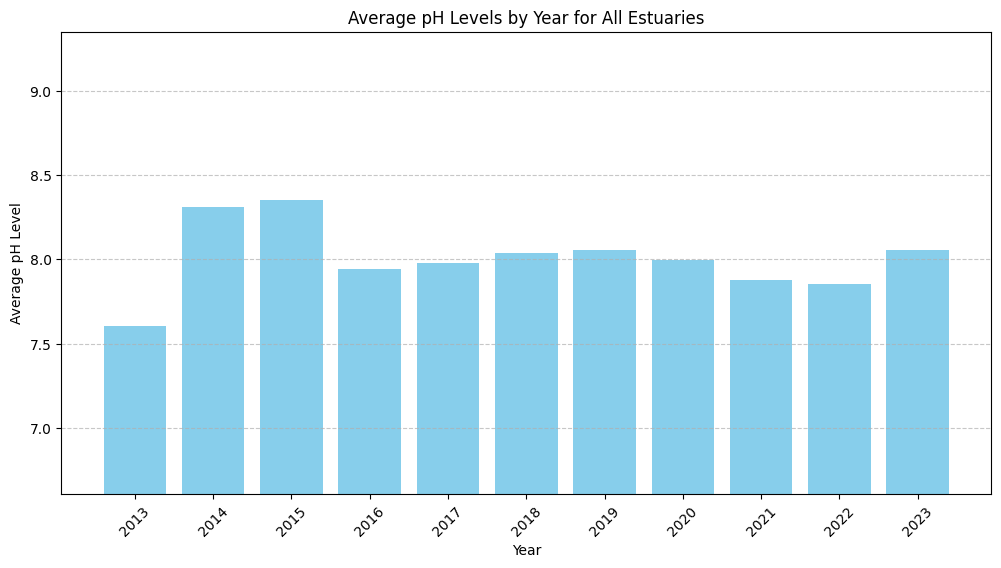

In [87]:
bushfire_data['Date'] = pd.to_datetime(bushfire_data['Date'])

bushfire_data['Year'] = bushfire_data['Date'].dt.year

avg_pH_per_year = bushfire_data.groupby(['Year'])['pH'].mean()

plt.figure(figsize=(12, 6))
plt.bar(avg_pH_per_year.index, avg_pH_per_year, color='skyblue')

plt.title('Average pH Levels by Year for All Estuaries')
plt.xlabel('Year')
plt.ylabel('Average pH Level')
plt.xticks(avg_pH_per_year.index, rotation=45)
plt.ylim(min(avg_pH_per_year) - 1, max(avg_pH_per_year) + 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The bar graph shows that most lakes stay around the 8 mark, other lakes are either more alkaline or acidic. For fresh waters, the general acceptable range is around 6 - 9. The average values  for each years show that the bushfire seems to lower the pH levels, albeit by a slight and safe amount. 

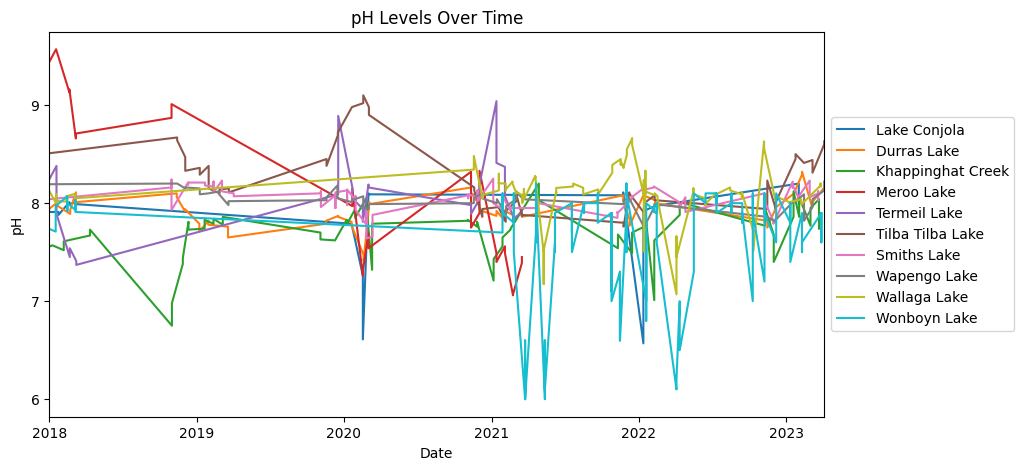

In [86]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "pH"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Meanwhile, the line graph shows more detail of the pH changes in each lakes. Rather than the level itself, its instability is worth taking note of. This is evident with the pH levels of Wonboyn lake, which keeps on hovering back and forth around the 6 and 8 mark. Instability can mess with an organism's ability to regulate their internal salt and water balance. Furthermore, it can decrease the amount of oxygen supply by affecting the their solubility in water. 

Aside from pH, Salinity can highly impact water quality. levels of dissolved salt in water increases from salt contained soil erosions that go into water. Due to lakes being freshwater, salinity levels are often very low. Increase of salinity that is out of the normal range may induce stress towards aquatic organisms. They may lower .........

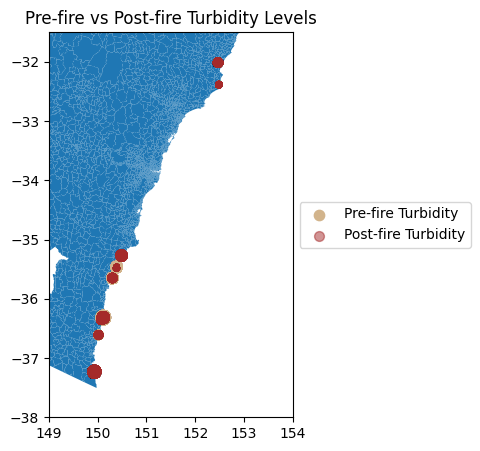

In [64]:
turbidity_data = pd.DataFrame({
    'Pre-fire': average_pre_fire["Turbidity (NTU)"],
    'Post-fire': average_post_fire["Turbidity (NTU)"]
})

lake_df = lake_df.join(turbidity_data, on='Estuary', rsuffix='_turbidity')

lake_df = gp.GeoDataFrame(lake_df, geometry='geometry')

ax = burbs.plot()
ax.set_xlim(left=149, right=154)
ax.set_ylim(top=-31.5, bottom=-38)

lake_df.plot(ax=ax, color='tan', alpha=1.0, markersize=lake_df['Pre-fire']*10, label='Pre-fire Turbidity')

lake_df.plot(ax=ax, color='brown', alpha=0.5, markersize=lake_df['Post-fire']*10, label='Post-fire Turbidity')

plt.title('Pre-fire vs Post-fire Turbidity Levels')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

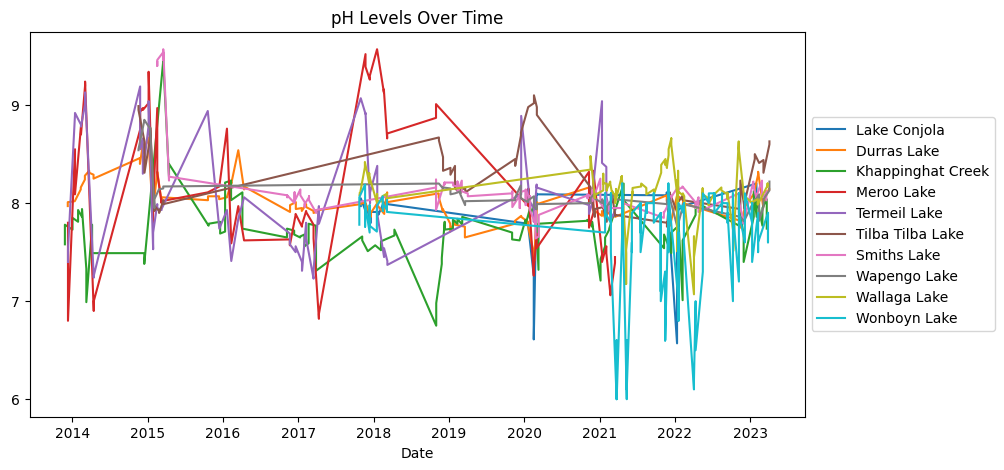

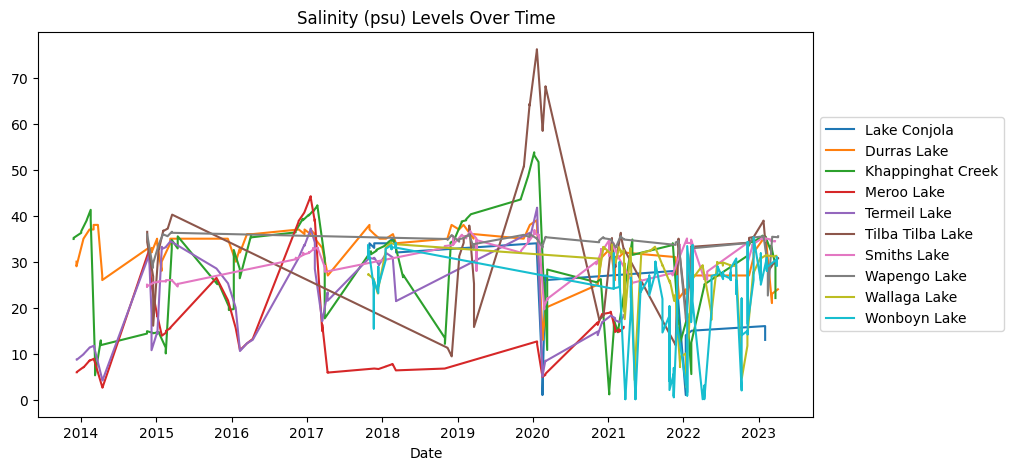

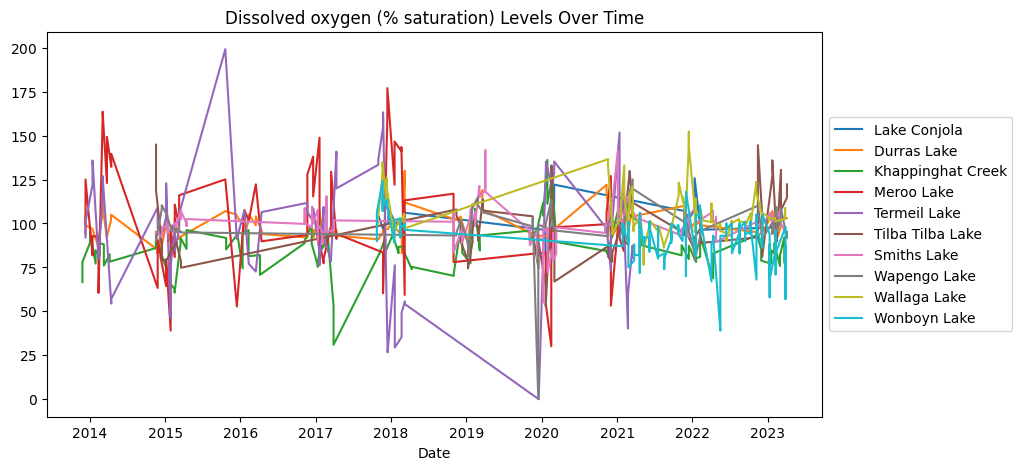

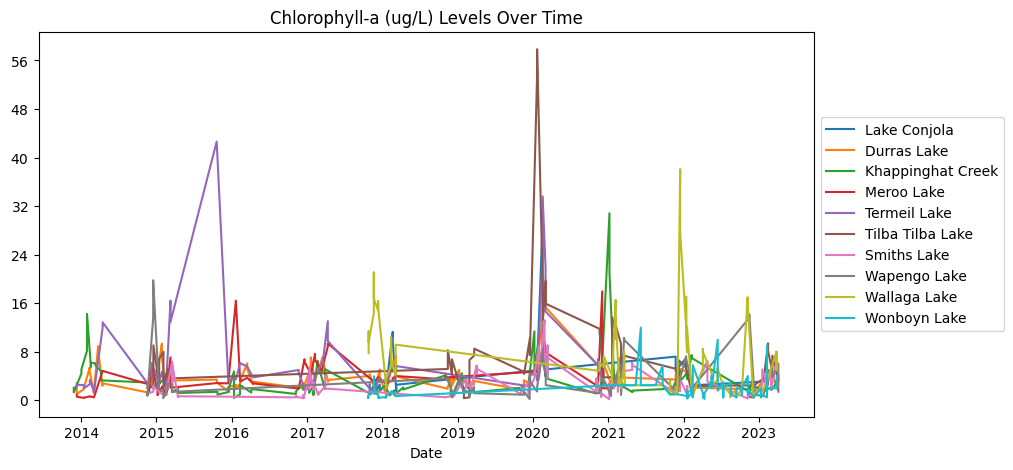

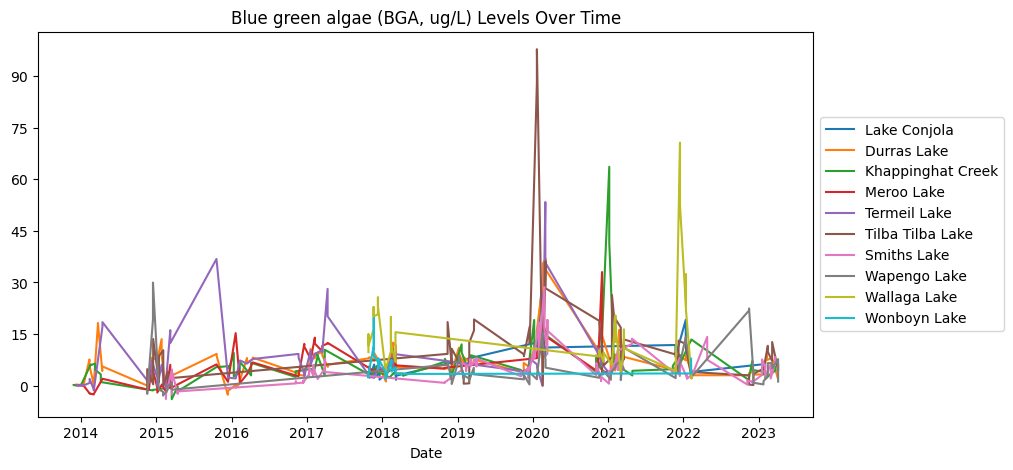

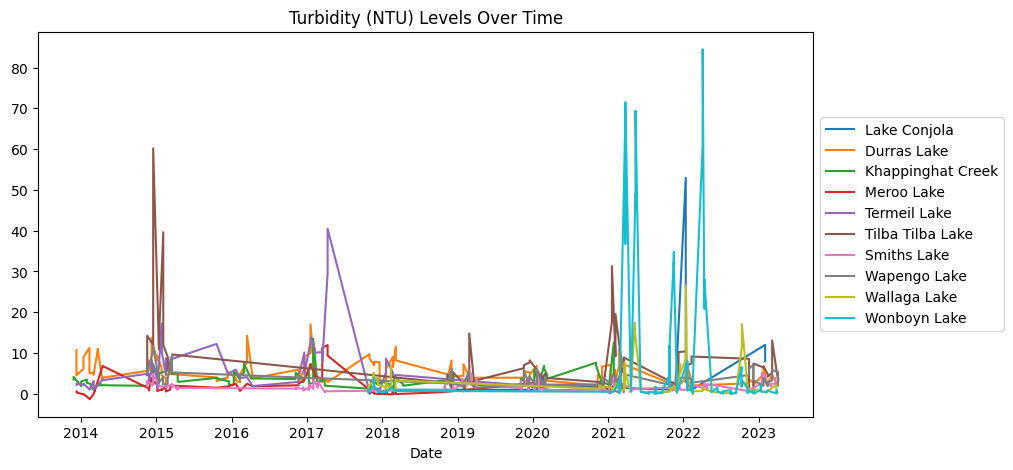

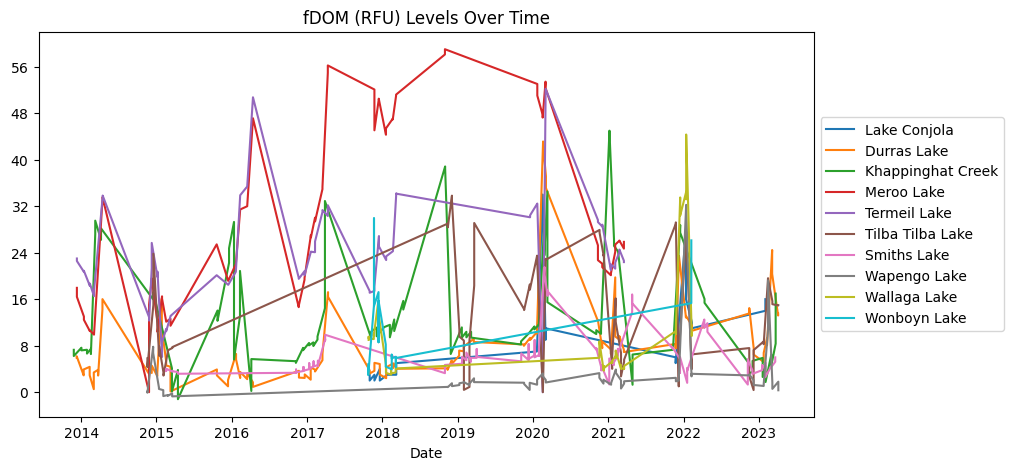

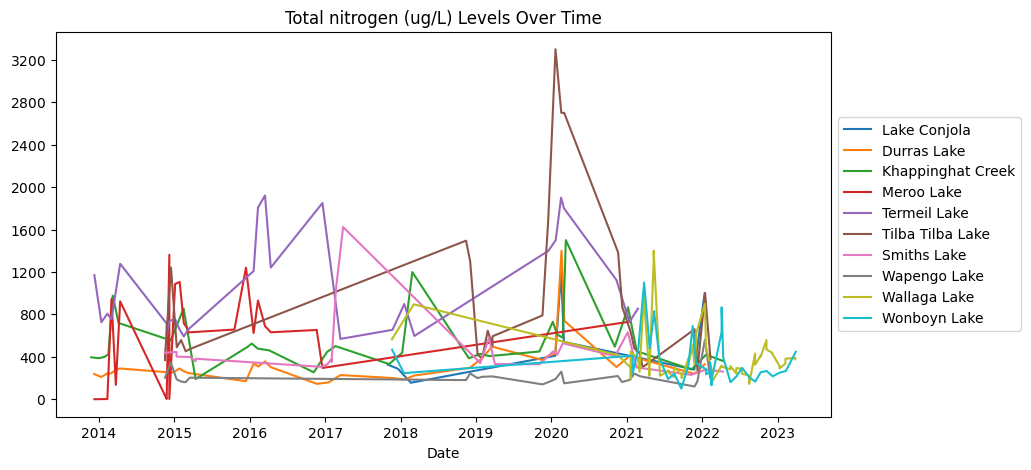

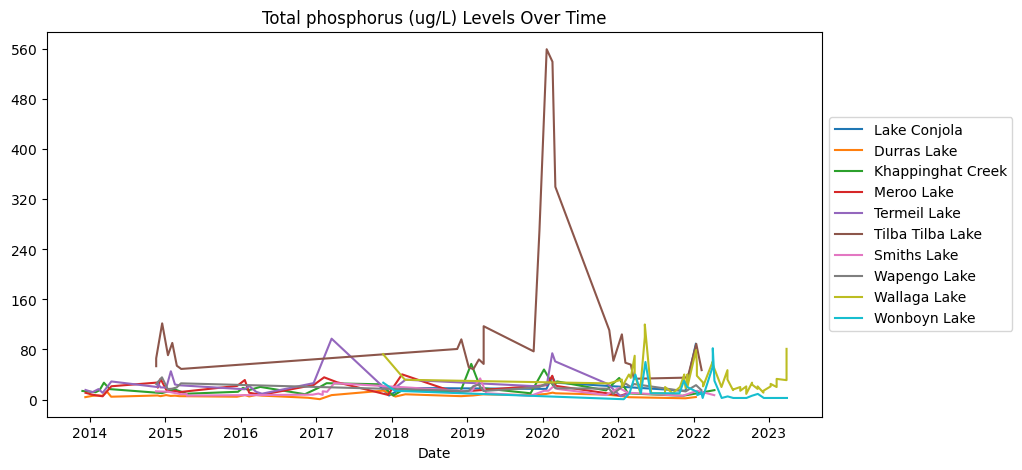

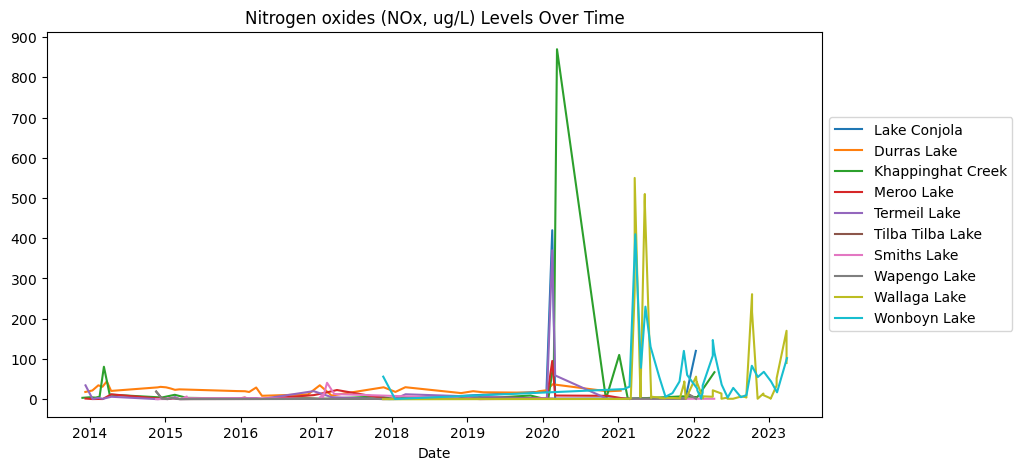

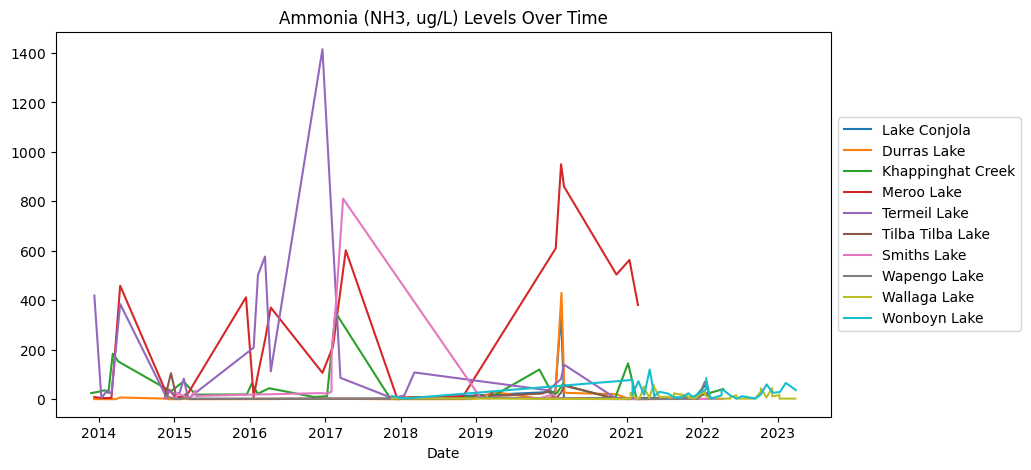

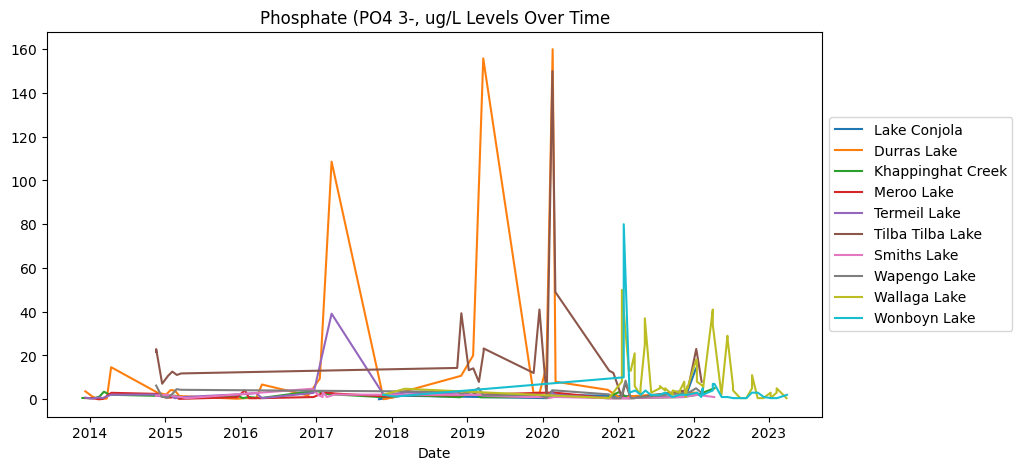

In [65]:
columns_to_plot = [
    "pH",
    "Salinity (psu)",
    "Dissolved oxygen (% saturation)",
    "Chlorophyll-a (ug/L)",
    "Blue green algae (BGA, ug/L)",
    "Turbidity (NTU)",
    "fDOM (RFU)",
    "Total nitrogen (ug/L)",
    "Total phosphorus (ug/L)",
    "Nitrogen oxides (NOx, ug/L)",
    "Ammonia (NH3, ug/L)",
    "Phosphate (PO4 3-, ug/L"
]

estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

for column in columns_to_plot:
    plt.figure()
    for estuary in estuaries:
        plot_estuary_data(bushfire_data, estuary, column)

    plt.title(f"{column} Levels Over Time")
    plt.xlabel("Date")

    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

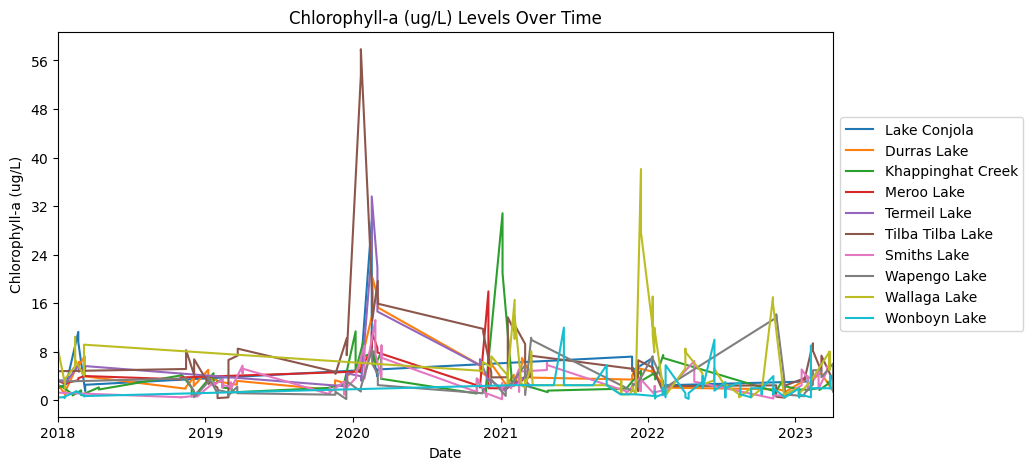

In [66]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "Chlorophyll-a (ug/L)"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

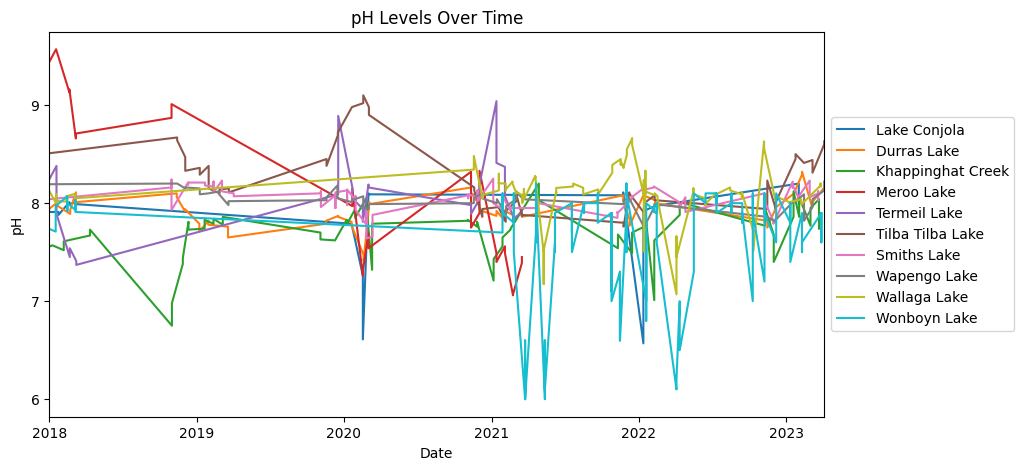

In [67]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "pH"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

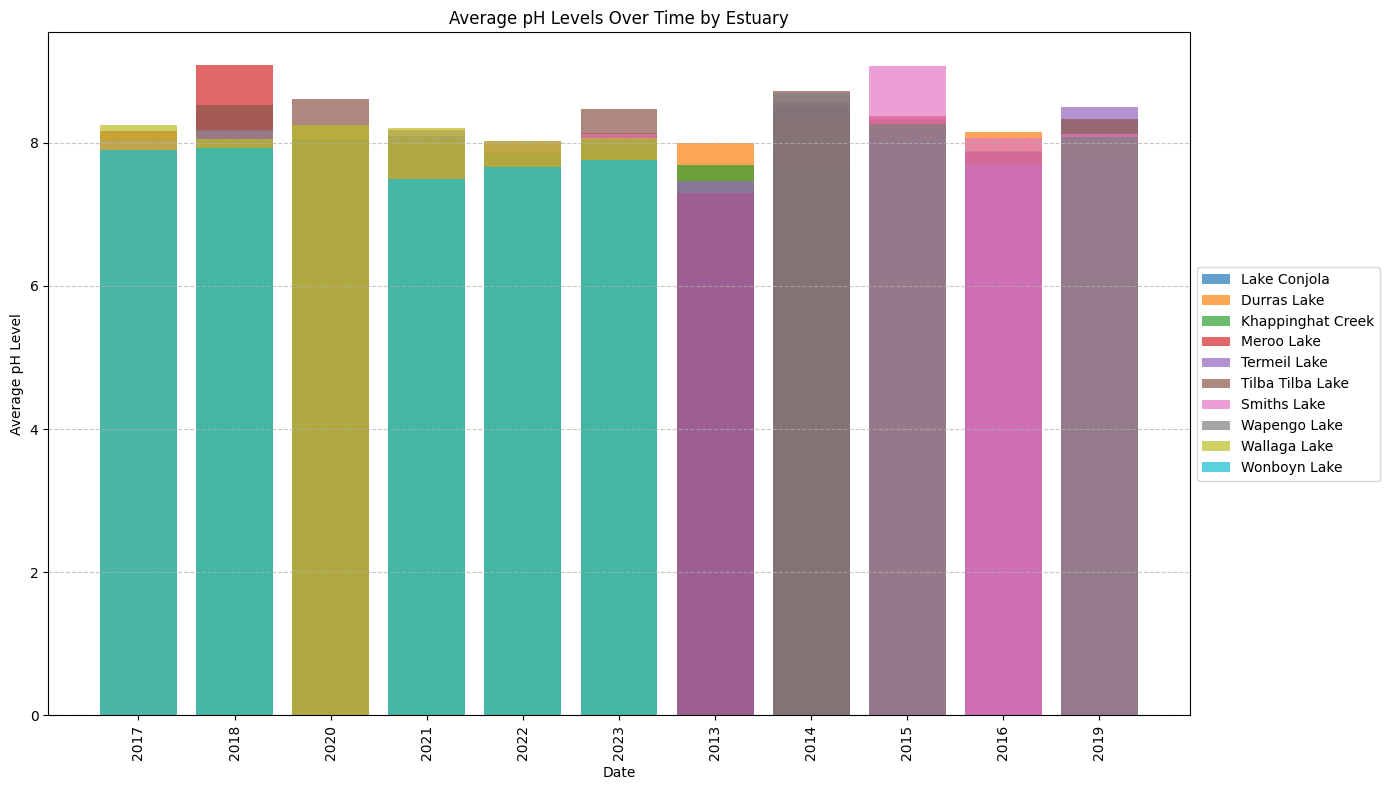

In [85]:
bushfire_data['Year'] = bushfire_data['Date'].dt.year

agg_pH_data = bushfire_data.groupby(['Estuary', 'Year'])['pH'].mean().reset_index()

estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

# Plot bar graph
plt.figure(figsize=(14, 8))
colors = plt.get_cmap('tab10').colors

for i, estuary in enumerate(estuaries):
    estuary_data = agg_pH_data[agg_pH_data['Estuary'] == estuary]
    plt.bar(estuary_data['Year'].astype(str), estuary_data['pH'], color=colors[i % len(colors)], label=estuary, alpha=0.7)

plt.title('Average pH Levels Over Time by Estuary')
plt.xlabel('Date')
plt.ylabel('Average pH Level')
plt.xticks(rotation=90) 
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


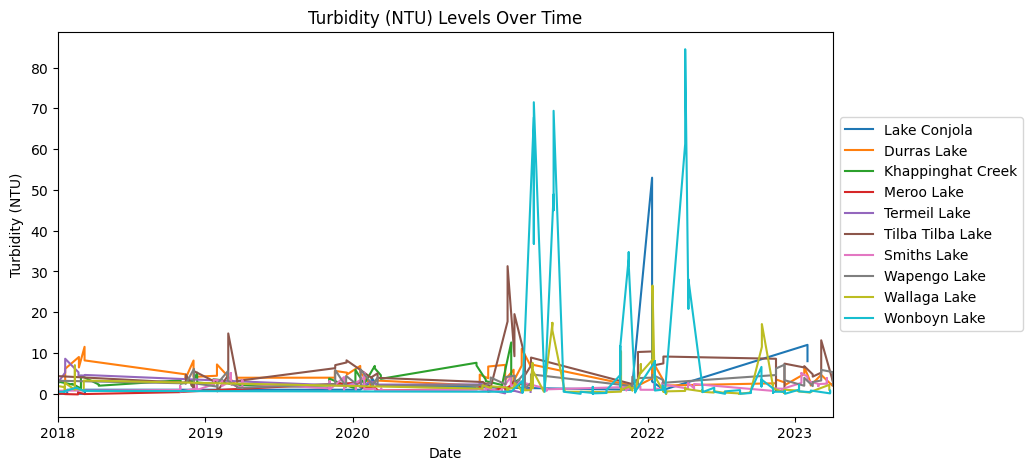

In [68]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "Turbidity (NTU)"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

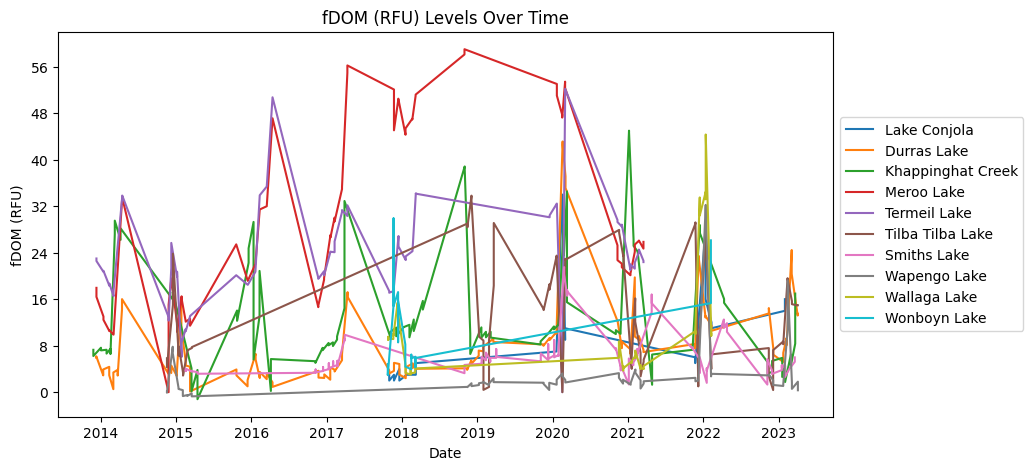

In [69]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "fDOM (RFU)"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

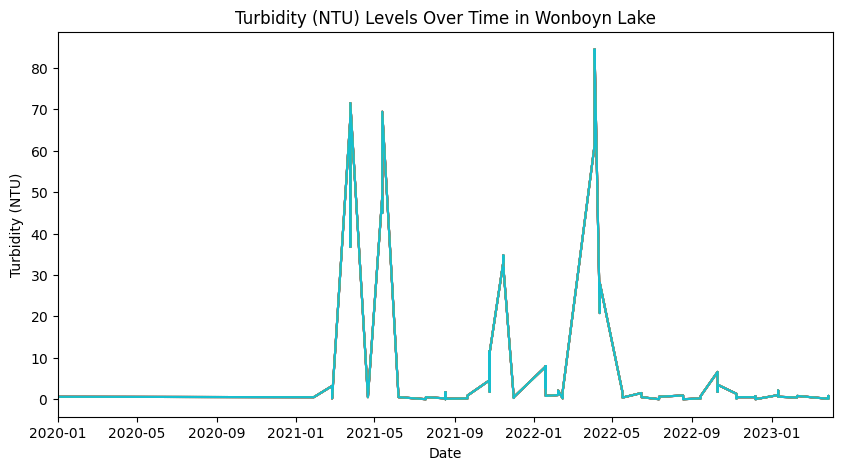

In [70]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "Turbidity (NTU)"
    plot_estuary_data(bushfire_data, "Wonboyn Lake", column)

plt.title(f"{column} Levels Over Time in Wonboyn Lake")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2020"), bushfire_data["Date"].max())
plt.ylabel(column)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)
plt.show()

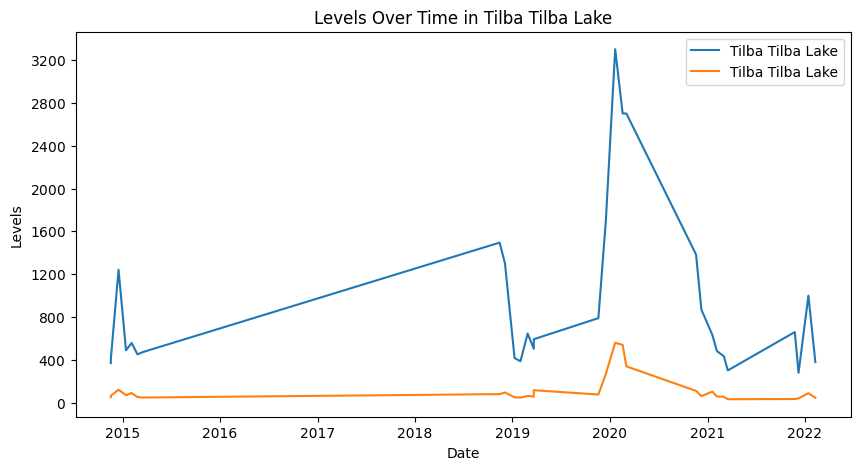

In [71]:
columns_to_plot = ["Total nitrogen (ug/L)", "Total phosphorus (ug/L)"]

estuaries = ["Tilba Tilba Lake"]

plt.figure()
for estuary in estuaries:
    for column in columns_to_plot:
        plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"Levels Over Time in {estuary}")
plt.xlabel("Date")
plt.ylabel("Levels")
plt.legend()
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)
plt.show()

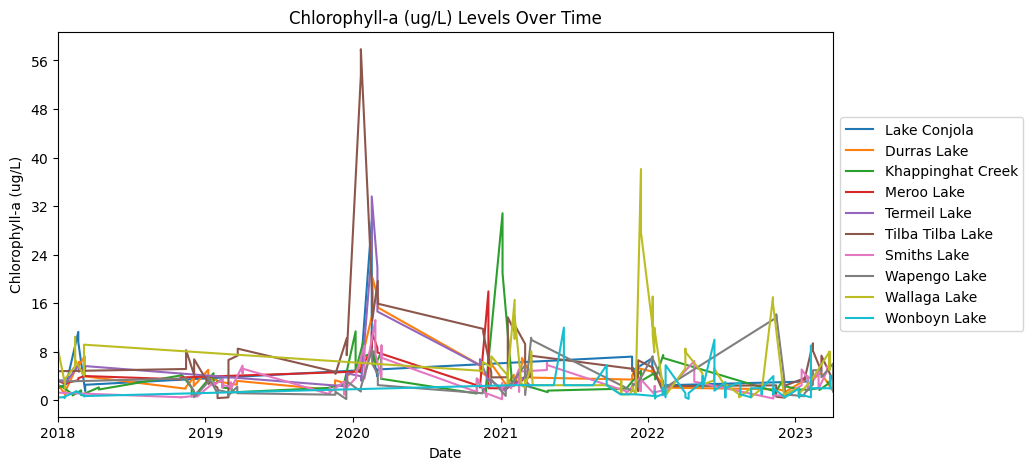

In [72]:
estuaries = [
    "Lake Conjola",
    "Durras Lake",
    "Khappinghat Creek",
    "Meroo Lake",
    "Termeil Lake",
    "Tilba Tilba Lake",
    "Smiths Lake",
    "Wapengo Lake",
    "Wallaga Lake",
    "Wonboyn Lake",
]

plt.figure()
for estuary in estuaries:
    column = "Chlorophyll-a (ug/L)"
    plot_estuary_data(bushfire_data, estuary, column)

plt.title(f"{column} Levels Over Time")
plt.xlabel("Date")
plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
plt.ylabel(column)

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().tick_params(axis="y", which="major", labelsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()